In [79]:
import numpy as np
import pygmt
import h5py
import xarray as xr

In [80]:
with h5py.File('./optimize/gradient_M06.h5') as f:
    # Read the data from the HDF5 file
    x = f['x'][:]
    y = f['y'][:]
    z = f['z'][:]
    ggc = f['Gc_kernel_smooth'][:]
    ggs = f['Gs_kernel_smooth'][:]

# max value of gradient
max_ggc = np.max(np.abs(ggc))
max_ggs = np.max(np.abs(ggs))
max_g = max(max_ggc, max_ggs)
enf = 1e20
max_g *= enf
print(max_ggc, max_ggs)

4.586257e-20 7.553598e-20


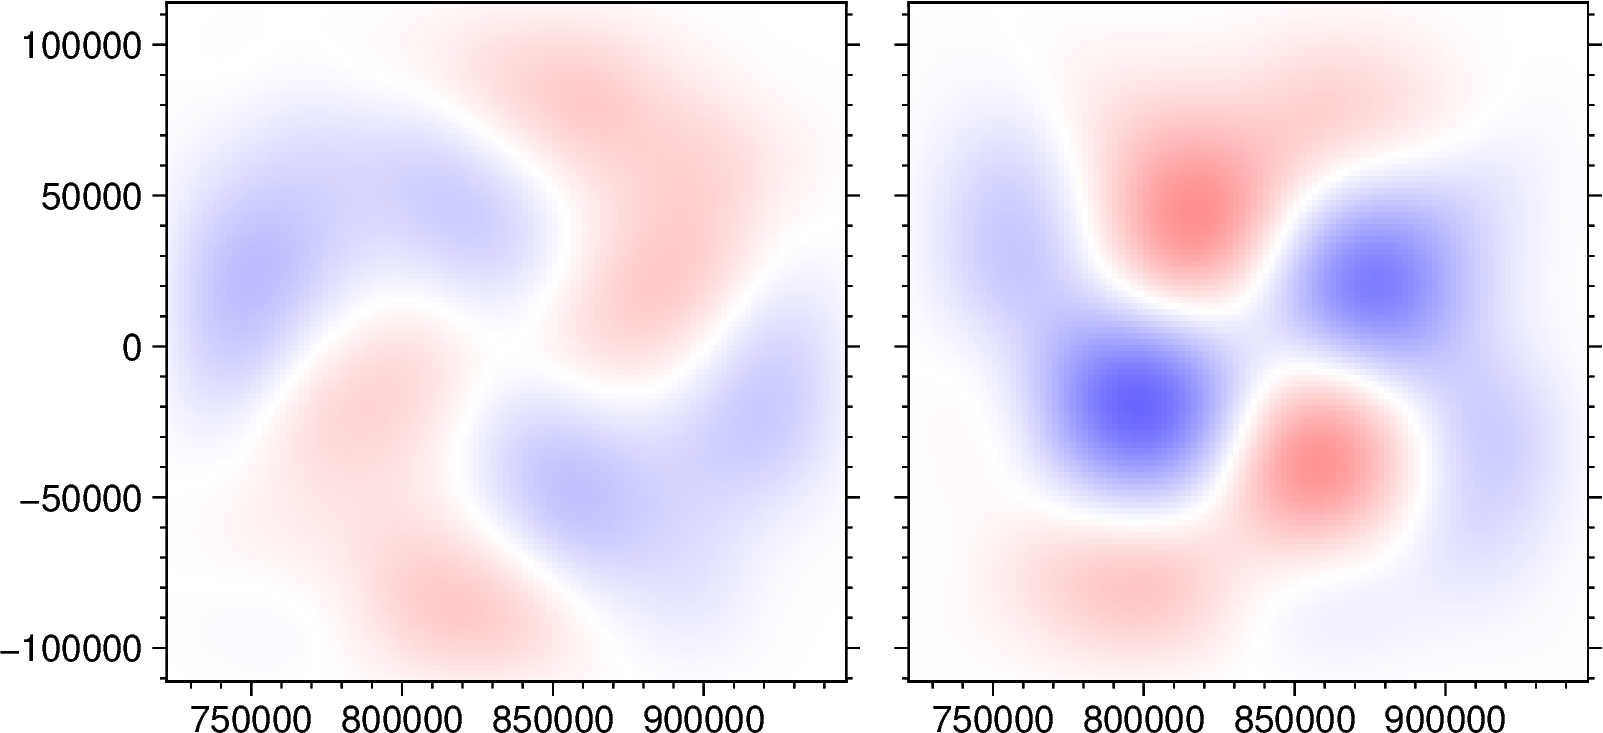

In [81]:
dep = -15000
# dep = -23000
iz = np.argmin(np.abs(z - dep))
fig = pygmt.Figure()
with fig.subplot(nrows=1, ncols=2, figsize=('12c', '6c'), sharey='l') :
    for mp in [ggc, ggs]:
        fig.basemap(region=[x.min(), x.max(), y.min(), y.max()], projection="x?", panel=True)
        grid = xr.DataArray(
            data=mp[:, :, iz].T*enf,
            dims=["y", "x"],
            coords=[y, x],
        )
        pygmt.makecpt(cmap='polar', series=[-max_g, max_g, max_g/10], continuous=True, reverse=True)
        fig.grdimage(
            grid=grid,
            cmap=True,
        )
fig.show()


In [ ]:
with h5py.File('./optimize/model_M07.h5') as f:
    # Read the data from the HDF5 file
    x = f['x'][:]
    y = f['y'][:]
    z = f['z'][:]
    mgcf = f['Gc'][:]
    mgsf = f['Gs'][:]


In [89]:
def flatten_phi(phi, g0, length=0.02, width=0.1, nskip=5):
    xx, yy = np.meshgrid(x[::nskip], y[::nskip], indexing='ij')
    phi_skip = phi[::nskip, ::nskip]
    g0_skip = g0[::nskip, ::nskip]
    phi_flat = np.array([xx.flatten(), yy.flatten(), phi_skip.flatten(), g0_skip.flatten()*length, np.ones_like(phi_skip.flatten())*width]).T
    return phi_flat

7.5335145 8.998019e-06


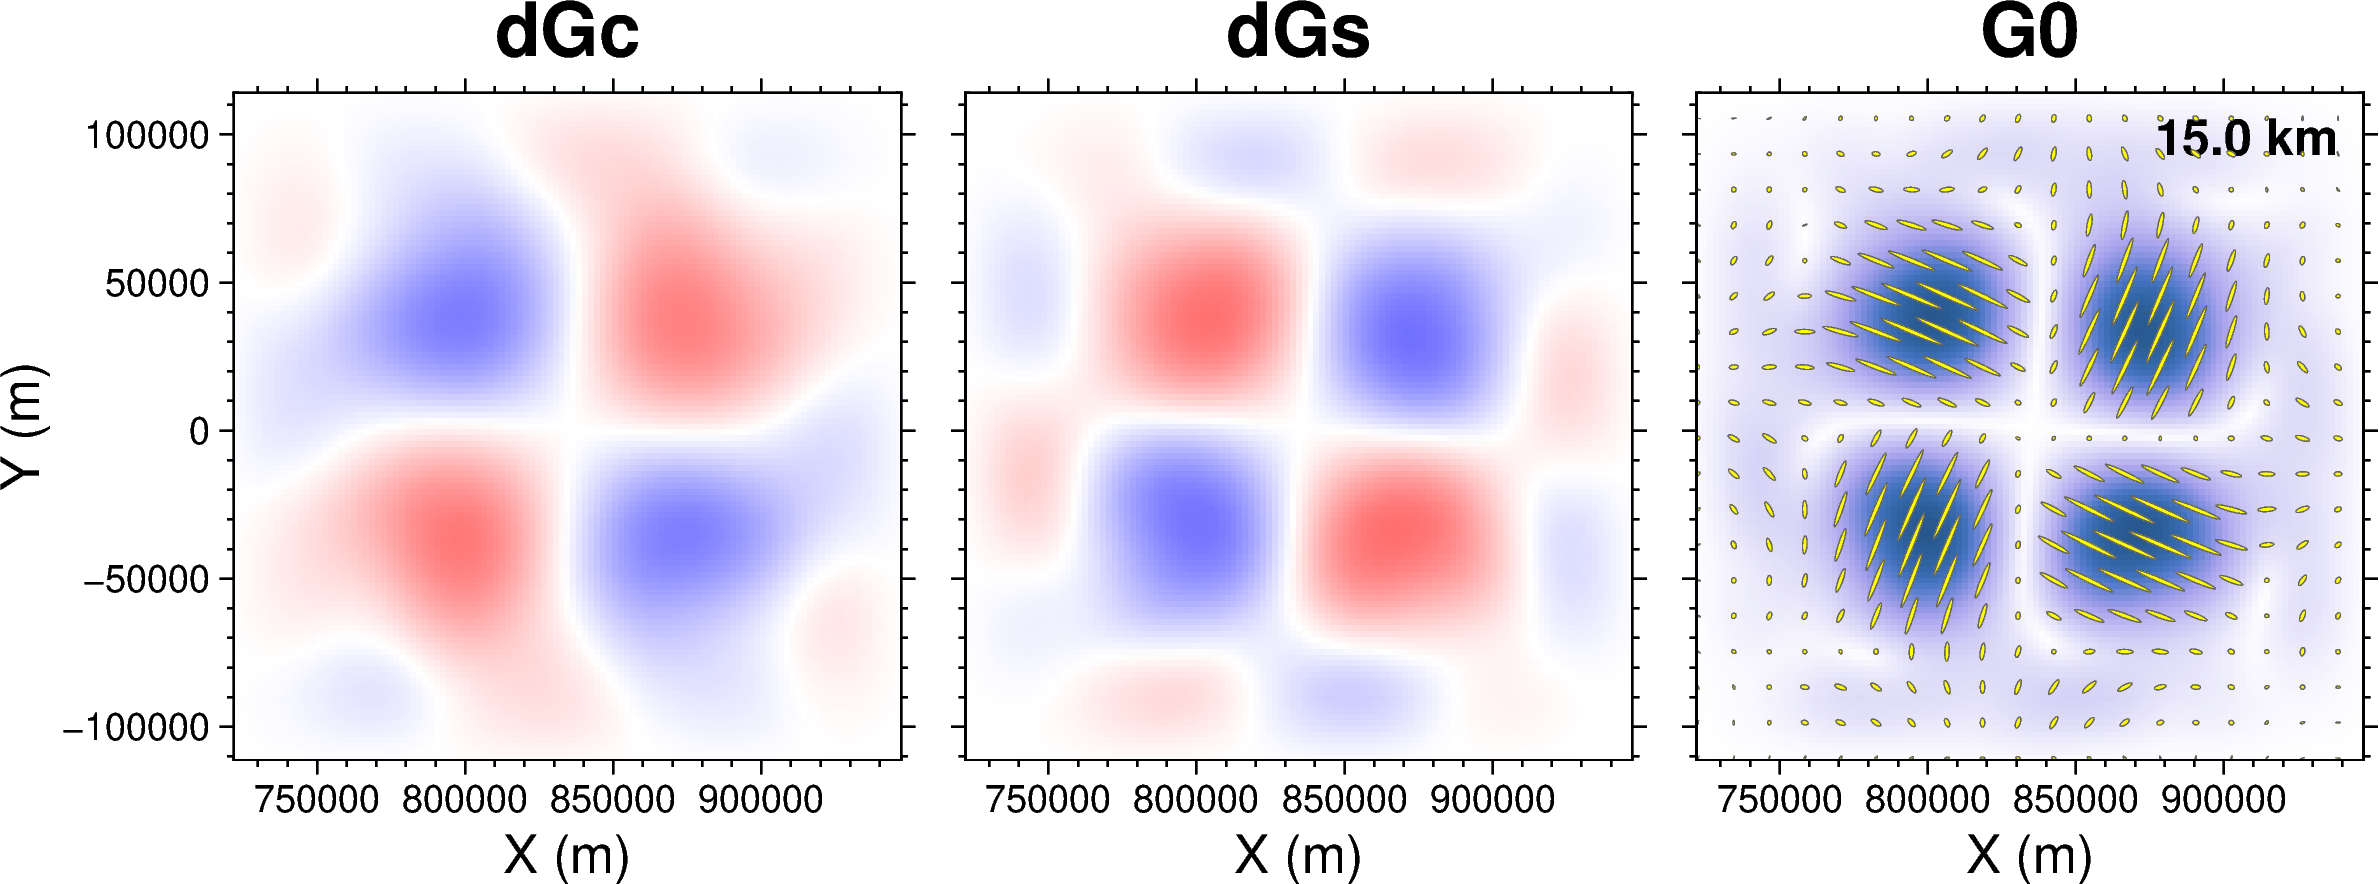

In [96]:
fig = pygmt.Figure()
phi = np.rad2deg(0.5*np.arctan2(mgsf, mgcf))
g0 = np.sqrt(mgcf**2 + mgsf**2)*100
print(g0.max(), g0.min())
with fig.subplot(nrows=1, ncols=3, figsize=('18c', '6c'), sharey='l', sharex='b', frame=['x+lX (m)', 'y+lY (m)']) :
    for i, mp in enumerate([mgcf, mgsf]):
        fig.basemap(region=[x.min(), x.max(), y.min(), y.max()], projection="x?", panel=True)
        grid = xr.DataArray(
            data=mp[:, :, iz].T*100,
            dims=["y", "x"],
            coords=[y, x],
        )
        
        pygmt.makecpt(cmap='polar', series=[-10, 10, 0.001], continuous=True, reverse=True)
        fig.grdimage(
            grid=grid,
            cmap=True,
        )
        if i == 0:
            fig.text(position="TC", text="dGc", font="18p,Helvetica-Bold,black", offset='0c/0.8c', no_clip=True)
        else:
            fig.text(position="TC", text="dGs", font="18p,Helvetica-Bold,black", offset='0c/0.8c', no_clip=True)
    fig.basemap(region=[x.min(), x.max(), y.min(), y.max()], projection="x?", panel=True)
    grid = xr.DataArray(
        data=g0[:, :, iz].T,
        dims=["y", "x"],
        coords=[y, x],
    )
    pygmt.makecpt(cmap='devon', series=[0, 10, 0.01], continuous=True, reverse=True)
    fig.grdimage(grid=grid, cmap=True)
    fig.text(position="TC", text="G0", font="18p,Helvetica-Bold,black", offset='0c/0.8c', no_clip=True)
    fig.text(position="TR", text="{} km".format(dep/-1000), font="12p,Helvetica-Bold,black", offset='-0.2c/-0.2c')
    ani = flatten_phi(phi[:, :, iz], g0[:, :, iz], length=0.08, width=0.04, nskip=6)
    fig.plot(ani, style='e', fill='yellow', pen='0.2p,100')
fig.show()